In [1]:
import os
import sys

import pandas as pd
import pandasql as ps
import numpy as np
from datetime import datetime, timedelta
import psycopg2
import matplotlib.pyplot as plt
from tqdm import tqdm

from constants import *

In [2]:
df = pd.read_csv('trips.csv')
df.head()

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app


In [3]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'datetime': 'date'})

In [4]:
def extract_coordinates(df, col):
    coord = []
    for i, row in df.iterrows():
        coord.append(row[col].split('(')[1].split(')')[0])
    df[col] = ""
    df[col] = coord


extract_coordinates(df, 'origin_coord')
extract_coordinates(df, 'destination_coord')
df.head()

,region,origin_coord,destination_coord,date,datasource
0,Prague,14.4973794438195 50.00136875782316,14.43109483523328 50.04052930943246,2018-05-28 09:03:40,funny_car
1,Turin,7.672837913286881 44.9957109242058,7.720368637535126 45.06782385393849,2018-05-21 02:54:04,baba_car
2,Prague,14.32427345662177 50.00002074358429,14.47767895969969 50.09339790740321,2018-05-13 08:52:25,cheap_mobile
3,Turin,7.541509189114433 45.09160503827746,7.74528653441973 45.02628598341506,2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,7.614078119815749 45.13433106465422,7.527497142312585 45.03335051325654,2018-05-23 12:45:54,pt_search_app


In [5]:
df['table_id'] = abs(df[['region', 'origin_coord', 'destination_coord', 'datasource']].sum(axis=1).map(hash))
df['region_id'] = abs(df[['region']].sum(axis=1).map(hash))
df['datasource_id'] = abs(df[['datasource']].sum(axis=1).map(hash))

In [6]:
trips_ft = df[['table_id', 'region_id', 'origin_coord', 'destination_coord', 'date', 'datasource_id']]
dim_region = df[['region_id', 'region']].drop_duplicates()
dim_datasource = df[['datasource_id', 'datasource']].drop_duplicates()

In [7]:
# Query to group by origin and destination coordinates
query1 = f"""
select 
b.region,
strftime('%Y-%m-%d', a.date) as date,
strftime('%Y', a.date) as year,
strftime('%m', a.date) as month,
strftime('%d', a.date) as day
from trips_ft a
left join dim_region b
on a.region_id = b.region_id 
group by
b.region, 
strftime('%Y', a.date),
strftime('%m', a.date),
strftime('%d', a.date)
"""
test = ps.sqldf(query1)
print(test.shape)
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
test.head()

(64, 5)


,region,date,year,month,day
0,Hamburg,2018-05-01,2018,05,01
1,Hamburg,2018-05-04,2018,05,04
2,Hamburg,2018-05-05,2018,05,05
3,Hamburg,2018-05-06,2018,05,06
4,Hamburg,2018-05-07,2018,05,07


In [8]:
# generate a dataframe for each region, appended by an index on the df_f dataframe

def filter_region(df, col): 
    regions = df[col].unique()
    for i in range(len(regions)):
        regions[i] = df[df[col]==regions[i]]
    return regions

df_f = filter_region(test, 'region')
print(df_f[1])
   


    region       date  year month day
21  Prague 2018-05-01  2018    05  01
22  Prague 2018-05-02  2018    05  02
23  Prague 2018-05-03  2018    05  03
24  Prague 2018-05-04  2018    05  04
25  Prague 2018-05-06  2018    05  06
26  Prague 2018-05-08  2018    05  08
27  Prague 2018-05-09  2018    05  09
28  Prague 2018-05-10  2018    05  10
29  Prague 2018-05-11  2018    05  11
30  Prague 2018-05-12  2018    05  12
31  Prague 2018-05-13  2018    05  13
32  Prague 2018-05-14  2018    05  14
33  Prague 2018-05-15  2018    05  15
34  Prague 2018-05-17  2018    05  17
35  Prague 2018-05-19  2018    05  19
36  Prague 2018-05-20  2018    05  20
37  Prague 2018-05-21  2018    05  21
38  Prague 2018-05-23  2018    05  23
39  Prague 2018-05-26  2018    05  26
40  Prague 2018-05-28  2018    05  28
41  Prague 2018-05-29  2018    05  29


In [9]:
# Generate the a week column by which we'll be grouping next the results 
for i in tqdm(range(len(df_f)), desc="Transformation process: Weekly frequency generation progress"):
    df_f[i]['week'] = df_f[i]['date'] - timedelta(days=7)


Transformation process: Weekly frequency generation progress:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\sacfd\AppData\Local\Temp\ipykernel_23176\1209239389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f[i]['week'] = df_f[i]['date'] - timedelta(days=7)
Transformation process: Weekly frequency generation progress: 100%|██████████| 3/3 [00:00<00:00, 1501.54it/s]


In [10]:
final = {}
for i in tqdm(range(len(df_f)), desc="Transformation process: Grouping the trips by region in weekly frequency progress"):
    final.update({'df_'+df_f[i]['region'].iloc[0]: df_f[i].groupby([pd.Grouper(key='week', freq='W-MON')]).count().reset_index()})

Transformation process: Grouping the trips by region in weekly frequency progress: 100%|██████████| 3/3 [00:00<00:00, 299.86it/s]


In [11]:
for key in final.keys():
    final[key] = final[key].rename(columns={'region': 'count'})
    final[key]['region'] = key.split('_')[1]
    final[key] = final[key][['region', 'week', 'count']]

In [12]:
for val in final.values():
    print(val)

    region       week  count
0  Hamburg 2018-04-30      5
1  Hamburg 2018-05-07      5
2  Hamburg 2018-05-14      5
3  Hamburg 2018-05-21      4
4  Hamburg 2018-05-28      2
   region       week  count
0  Prague 2018-04-30      5
1  Prague 2018-05-07      7
2  Prague 2018-05-14      5
3  Prague 2018-05-21      3
4  Prague 2018-05-28      1
  region       week  count
0  Turin 2018-04-30      5
1  Turin 2018-05-07      4
2  Turin 2018-05-14      5
3  Turin 2018-05-21      6
4  Turin 2018-05-28      2


Transformation process: Plotting results progress:   0%|          | 0/3 [00:00<?, ?it/s]

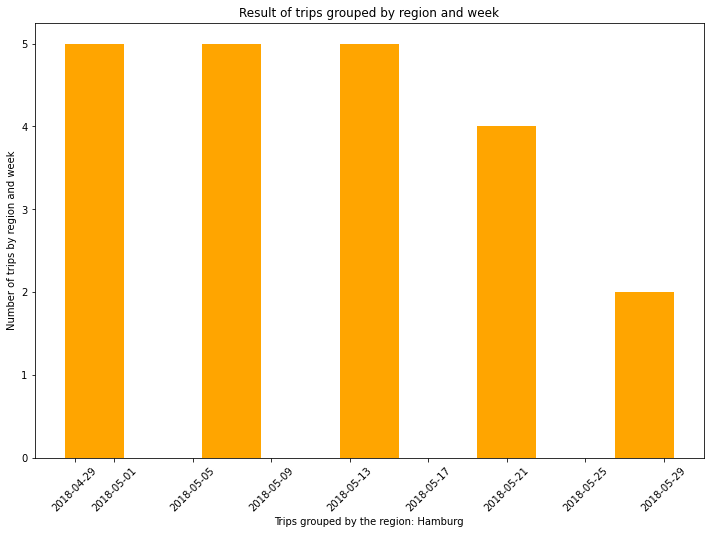

Transformation process: Plotting results progress:  33%|███▎      | 1/3 [00:00<00:00,  8.74it/s]

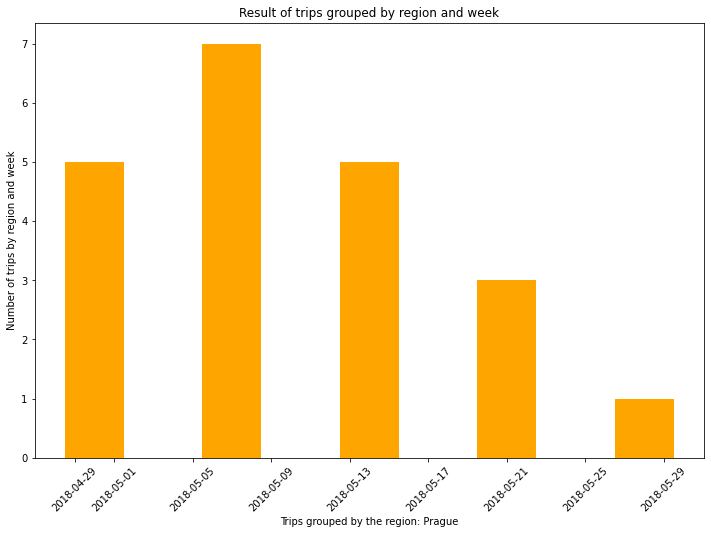

Transformation process: Plotting results progress:  67%|██████▋   | 2/3 [00:00<00:00,  6.74it/s]

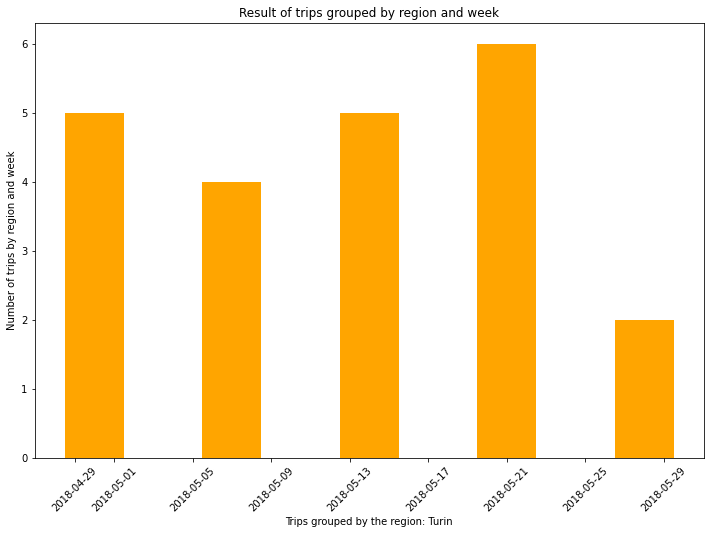

Transformation process: Plotting results progress: 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


In [13]:
## Plotting the results of the trips grouped by region and week
for key in tqdm(final.keys(), desc= "Transformation process: Plotting results progress: "):
    fig = plt.figure(figsize = (12, 8))
    plt.bar(final[key]['week'], final[key]['count'], color ='orange', width = 3)
    plt.xticks(rotation=45)
    plt.xlabel('Trips grouped by the region: ' + key.split('_')[1])
    plt.ylabel("Number of trips by region and week")
    plt.title("Result of trips grouped by region and week")
    plt.show()


### Connecting to the postgresql database

In [14]:
#Connection parameters
# Host = '127.0.0.1'
# Port = '5432'
# Db = 'challenge'
# User = 'challenge'
# Password = 'Jobsity'

In [15]:
#Create the connection string to connect to database
conn = psycopg2.connect(host = Host, database = Db, port = Port, user = User, password = Password)
cur = conn.cursor()

In [16]:
# Sql query to create the Trips fact table
create_trips_fact_table = (f"""CREATE TABLE IF NOT EXISTS trips_ft
(table_id bigint not null primary key,
region_id bigint not null, 
origin_coord varchar,
destination_coord varchar, 
date timestamp,
datasource_id bigint not null);
""")

In [17]:
trips_ft.dtypes

table_id                      int64
region_id                     int64
origin_coord                 object
destination_coord            object
date                 datetime64[ns]
datasource_id                 int64
dtype: object

In [18]:
# Sql query to create the region dimension table
create_region_dim_table = (f"""CREATE TABLE IF NOT EXISTS dim_region
(region_id bigint not null primary key,
region varchar);
""")

In [19]:
# Sql query to create the datasource dimension table
create_datasource_dim_table = (f"""CREATE TABLE IF NOT EXISTS dim_datasource
(datasource_id bigint not null primary key,
datasource varchar);
""")

In [20]:
# Sql query to create the grouped table of the second requirement
create_trips_group_table = (f"""CREATE TABLE IF NOT EXISTS results_table_1
(region varchar, 
date timestamp,
year varchar,
month varchar,
day varchar);
""")

In [21]:
#Function to create the table
def create_table(cur, conn, query_name):
    cur.execute(query_name)
    conn.commit()

In [22]:
create_table(cur, conn, create_trips_fact_table)
create_table(cur, conn, create_region_dim_table)
create_table(cur, conn, create_datasource_dim_table)
create_table(cur, conn, create_trips_group_table)

#### Loading data into the table in psql

In [23]:
def insert_fact_table(cur, table_id, region_id, origin_coord, destination_coord, date, datasource_id):
    
    insert_data = (f"""insert into trips_ft
    (table_id, region_id, origin_coord, destination_coord, date, datasource_id)
    values(%s, %s, %s, %s, %s, %s)""")

    data_to_insert = (table_id, region_id, origin_coord, destination_coord, date, datasource_id)
    cur.execute(insert_data, data_to_insert)

In [24]:
def write_fact_table(cur, data):
    for i, row in tqdm(data.iterrows(), desc="Ingestion process: fact table progress:"):
        insert_fact_table(cur, row['table_id'], row['region_id'], row['origin_coord'], row['destination_coord'], row['date'], row['datasource_id'])

In [25]:
def insert_dim_region(cur, region_id, region):
    
    insert_data = (f"""insert into dim_region
    (region_id, region)
    values(%s, %s)""")

    data_to_insert = (region_id, region)
    cur.execute(insert_data, data_to_insert)

In [26]:
def write_dim_region(cur, data):
    for i, row in tqdm(data.iterrows(), desc="Ingestion process: dim region table progress:"):
        insert_dim_region(cur, row['region_id'], row['region'])

In [27]:
def insert_dim_datasource(cur, datasource_id, datasource):
    
    insert_data = (f"""insert into dim_datasource
    (datasource_id, datasource)
    values(%s, %s)""")

    data_to_insert = (datasource_id, datasource)
    cur.execute(insert_data, data_to_insert)

In [28]:
def write_dim_datasource(cur, data):
    for i, row in tqdm(data.iterrows(), desc="Ingestion process: dim datasource table progress:"):
        insert_dim_datasource(cur, row['datasource_id'], row['datasource'])

In [29]:
test.dtypes

region            object
date      datetime64[ns]
year              object
month             object
day               object
dtype: object

In [30]:
def insert_results_1(cur, region, date, year, month, day):
    
    insert_data = (f"""insert into results_table_1
    (region, date, year, month, day)
    values(%s, %s, %s, %s, %s)""")

    data_to_insert = (region, date, year, month, day)
    cur.execute(insert_data, data_to_insert)

In [31]:
def write_results_1(cur, data):
    for i, row in tqdm(data.iterrows(), desc="Ingestion process: results table progress:"):
        insert_results_1(cur, row['region'], row['date'], row['year'], row['month'], row['day'])

In [32]:
write_fact_table(cur, trips_ft)
write_dim_region(cur, dim_region)
write_dim_datasource(cur, dim_datasource)
write_results_1(cur, test)
conn.commit()

Ingestion process: fact table progress:: 100it [00:00, 2987.93it/s]
Ingestion process: dim region table progress:: 3it [00:00, 3006.67it/s]
Ingestion process: dim datasource table progress:: 5it [00:00, 2503.76it/s]
Ingestion process: results table progress:: 64it [00:00, 2666.41it/s]
